# Demonstration for Time series forecasting

Forecasting for the count infected by COVID-19 (USA)

Author: Jim Xie

Date: 2020-7-20

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error, r2_score
import json
plt.style.use({'figure.figsize':(12, 5)})
sns.set_style('dark')
sns.set_context("poster")
pd.set_option('display.float_format',lambda x : '%.8f' % x)
plt.rcParams['axes.unicode_minus'] = False
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Prepare train data

In [2]:
df = pd.read_csv('./US/us_states_covid19_daily.csv')
df = pd.read_csv('./US-812/us_states_covid19_daily.csv')
df = pd.read_csv('./US-830/us_states_covid19_daily.csv')
df = df[['date','state','positive','positiveIncrease','total','totalTestResultsIncrease']]

df['date'] = df['date'].astype(str)
df = df[df['date']>='20200401']
df.fillna(value=0,inplace=True)
df.rename(columns={'total':'test', 'totalTestResultsIncrease':'testIncrease'}, inplace = True)
df.sort_values('date',ascending=True,inplace=True)
df.head(5)

,date,state,positive,positiveIncrease,test,testIncrease
8455,20200401,WY,130.00000000,21,2348,240
8424,20200401,MI,20246.00000000,1592,50197,5209
8423,20200401,ME,344.00000000,41,6432,41
8422,20200401,MD,1985.00000000,325,19218,2690
8421,20200401,MA,7639.00000000,1118,51764,4803


In [3]:
df1 = df.groupby(['date'])['positive','positiveIncrease','test','testIncrease'].agg('sum')
df1.sort_values('date',ascending=True,inplace=True)
df1 = df1.reset_index()
df1

,date,positive,positiveIncrease,test,testIncrease
0,20200401,224089.00000000,25785,1268243,108383
1,20200402,252146.00000000,28057,1389790,119310
2,20200403,284222.00000000,32076,1522758,132623
3,20200404,317434.00000000,33212,1705629,229559
4,20200405,342934.00000000,25500,1827162,119489
...,...,...,...,...,...
146,20200825,5750167.00000000,36374,73379496,645605
147,20200826,5793523.00000000,43356,74054514,654963
148,20200827,5837507.00000000,43984,74803661,751897
149,20200828,5884053.00000000,46546,75575177,783235


In [4]:
df_train,df_test,df_train,df_test = train_test_split(df1,df1,test_size=0.10,shuffle=False)
train_count = len(df_train)
test_count = len(df_test)

key = 'positiveIncrease'
raw_train_x = df1[key][0:train_count-1]
raw_train_y = df1[key][1:train_count]

raw_test_x = df1[key][train_count-2:-1]
raw_test_y = df1[key][train_count-1:]
test_date = df1['date'][train_count-1:]

sc = StandardScaler()
sc.fit(df[key][:,np.newaxis])

scaled_train_x = sc.transform(raw_train_x[:, np.newaxis])
scaled_train_y = sc.transform(raw_train_y[:, np.newaxis])
scaled_test_x = sc.transform(raw_test_x[:, np.newaxis])
scaled_test_y = sc.transform(raw_test_y[:, np.newaxis])

X_train = scaled_train_x
Y_train = scaled_train_y

X_test = scaled_test_x
Y_test = scaled_test_y

In [5]:
raw_train_x

0      25785
1      28057
2      32076
3      33212
4      25500
       ...  
129    53713
130    50624
131    42089
132    55702
133    56132
Name: positiveIncrease, Length: 134, dtype: int64

In [6]:
raw_test_x

133    56132
134    51760
135    55635
136    56148
137    42487
138    37881
139    40796
140    44953
141    43758
142    46562
143    46242
144    37567
145    34641
146    36374
147    43356
148    43984
149    46546
Name: positiveIncrease, dtype: int64

X_train = np.array(raw_train_x)
Y_train = np.array(raw_train_y)

X_test = np.array(raw_test_x)
Y_test = np.array(raw_test_y)

<AxesSubplot:>

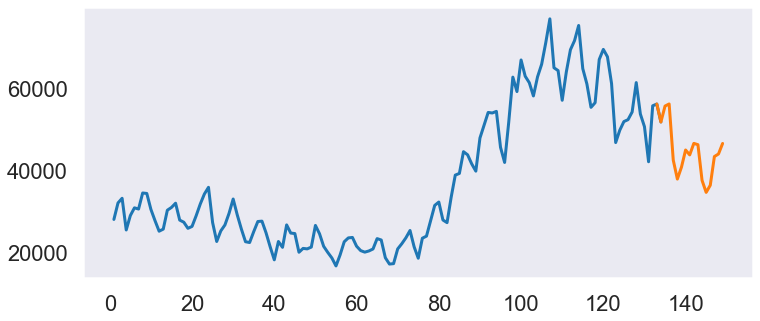

In [7]:
plt.ticklabel_format(style='plain',axis='both')    
raw_train_y.plot()
raw_test_x.plot()

# 使用原始神经网络

In [8]:
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import Adam
import keras.backend as K

K.clear_session()
model = Sequential()
model.add(Dense(50, input_dim=1, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0001))
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100,verbose=0)

In [9]:
X_test_NN = X_test
pred_nn_scaled = model.predict(X_test_NN)
pred_nn = sc.inverse_transform(pred_nn_scaled)

<AxesSubplot:>

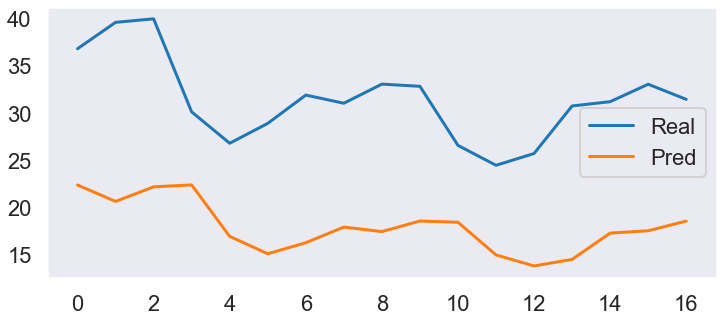

In [10]:
df_nn = pd.DataFrame()
df_nn['Real'] = Y_test.squeeze()
df_nn['Pred'] = pred_nn_scaled
df_nn.plot()

In [11]:
print('MSE: %f'%mean_squared_error(Y_test,pred_nn_scaled))
print('RMSE: %f'%np.sqrt(mean_squared_error(Y_test,pred_nn_scaled)))
print('R-Squared: %f'%r2_score(Y_test,pred_nn_scaled))

for date,real,pred in zip(test_date,raw_test_y,pred_nn):
    print(date,"Real:",real,"Predict:",pred[0],"Error:",real-pred[0])

MSE: 191.102789
RMSE: 13.823993
R-Squared: -9.472964
20200813 Real: 51760 Predict: 31752.947 Error: 20007.052734375
20200814 Real: 55635 Predict: 29333.92 Error: 26301.080078125
20200815 Real: 56148 Predict: 31477.957 Error: 24670.04296875
20200816 Real: 42487 Predict: 31761.795 Error: 10725.205078125
20200817 Real: 37881 Predict: 24203.18 Error: 13677.8203125
20200818 Real: 40796 Predict: 21654.684 Error: 19141.31640625
20200819 Real: 44953 Predict: 23267.549 Error: 21685.451171875
20200820 Real: 43758 Predict: 25567.617 Error: 18190.3828125
20200821 Real: 46562 Predict: 24906.42 Error: 21655.580078125
20200822 Real: 46242 Predict: 26457.871 Error: 19784.12890625
20200823 Real: 37567 Predict: 26280.818 Error: 11286.181640625
20200824 Real: 34641 Predict: 21480.947 Error: 13160.052734375
20200825 Real: 36374 Predict: 19861.994 Error: 16512.005859375
20200826 Real: 43356 Predict: 20820.861 Error: 22535.138671875
20200827 Real: 43984 Predict: 24683.996 Error: 19300.00390625
20200828 Real

In [12]:
X_train_t = X_train[:,None]
X_test_t = X_test[:,None]
X_train_t = X_train_t.reshape(-1,1,1)
X_test_t = X_test_t.reshape(-1,1,1)

# 使用LSTM

In [ ]:
K.clear_session()
model = Sequential()
#model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(1, 1)))
#model.add(Bidirectional(LSTM(20)))
model.add(LSTM(7, input_shape=(1,1),activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001))
model.fit(X_train_t, Y_train, validation_data=(X_test_t, Y_test), epochs=300000, verbose=0)
plt.plot(model.history.history['val_loss'])

In [ ]:
#X_test_LSTM = np.insert(X_test,0,Y_train[-1][0]).reshape(-1,1)
#X_test_LSTM = X_test_LSTM[:,None]
X_test_LSTM = X_test.reshape(-1,1,1)
pred_lstm_scaled = model.predict(X_test_LSTM)
pred_lstm = sc.inverse_transform(pred_lstm_scaled)

In [ ]:
plt.figure(figsize=(20,6))
df_t = pd.DataFrame()
df_t['Real'] = Y_test.squeeze()
df_t['Pred'] = pred_lstm_scaled
df_t.plot()

In [ ]:
print('MSE: %f'%mean_squared_error(df_t['Real'],pred_lstm_scaled))
print('RMSE: %f'%np.sqrt(mean_squared_error(df_t['Real'],pred_lstm_scaled)))
print('R-Squared: %f'%r2_score(df_t['Real'],pred_lstm_scaled))

for date,real,pred in zip(test_date,raw_test_y,pred_lstm):
    print(date,"Real:",real,"Predict:",pred[0],"Error:",real-pred[0])